# SpamHam Text Classification

<b> Imports</b>

In [1]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Making the data sets

In [2]:
# I've copied all spam and ham emails in singel directory 'emails', now making the data.
def make_data():
    direc = 'emails/'
    files = os.listdir(direc)
    emails = np.array([direc+email for email in files])
    
    random.shuffle(emails)
    
    email_col = np.array([[]])
    label = np.array([[]])
    c = len(emails)
    for email in emails:
        f = open(email, encoding='utf8', errors='ignore')
        blob = f.read()
        email_col = np.append(email_col, blob)
        if 'ham' in email:
            label = np.append(label, 'ham')
        if 'spam' in email:
            label = np.append(label, 'spam')
        c-=1
        print(c)
        
    return email_col, label
        

In [4]:
#emails, labels = make_data()

In [8]:
emails.shape, labels.shape

((5172,), (5172,))

In [9]:
# making them dimension ready
emails = emails[:, np.newaxis]
labels = labels[:, np.newaxis]

In [11]:
emails.shape, labels.shape

((5172, 1), (5172, 1))

In [13]:
df = pd.DataFrame({'message': emails.flatten(), 'labels':labels.flatten()}, index=np.arange(5172))

In [14]:
df.head()

,labels,message
0,spam,Subject: special promotion - get a las vegas v...
1,ham,Subject: re : enron / hpl actuals for august 1...
2,ham,Subject: re : enron industrial markets - super...
3,ham,Subject: revision # 1 - enron / hpl actuals fo...
4,spam,Subject: legal operating systems for a third o...


preprocess email data

In [15]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def purify_text(message):
    soup = BeautifulSoup(message)
    text =  soup.get_text()
    text = text.replace("\n", " ").replace("/", "").replace("|", "").replace("http", "").replace(':', "").replace('\t', "").replace("Subject", "").replace('re', "").strip()
    tokens = word_tokenize(text)
    temp = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    return ' '.join(temp)

df['message'] = df['message'].apply(purify_text)


In [16]:
df.head()

,labels,message
0,spam,special promotion - get a la vega vacation for...
1,ham,"enron hpl actuals for august 11 - 13 , 2000 vi..."
2,ham,enron industrial market - super saturday cruit...
3,ham,"vision # 1 - enron hpl actuals for july 5 , 20..."
4,spam,legal operating system for a third of the pric...


Adding sms spam data to this dataset.

In [19]:
df_sms = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['labels', 'message'])

In [20]:
df_sms.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
df_sms['message'] = df_sms['message'].apply(purify_text)

In [22]:
df_sms.head()

,labels,message
0,ham,"go until jurong point , crazy.. available only..."
1,ham,ok lar ... joking wif u oni ...
2,spam,fe entry in 2 a wkly comp to win fa cup final ...
3,ham,u dun say so early hor ... u c alady then say ...
4,ham,"nah i do n't think he go to usf , he life arou..."


Merging the two datasets

In [25]:
df_final = df.merge(df_sms, how='outer')

In [26]:
df_final.head()

,labels,message
0,spam,special promotion - get a la vega vacation for...
1,ham,"enron hpl actuals for august 11 - 13 , 2000 vi..."
2,ham,enron industrial market - super saturday cruit...
3,ham,"vision # 1 - enron hpl actuals for july 5 , 20..."
4,spam,legal operating system for a third of the pric...


In [27]:
df_final.tail()

,labels,message
10739,spam,this is the 2nd time we have tried 2 contact u...
10740,ham,will ü b going to esplanade fr home ?
10741,ham,"pity , * wa in mood for that . so ... any othe..."
10742,ham,the guy did some bitching but i acted like i '...
10743,ham,rofl . it true to it name


In [29]:
df_final = df_final.sample(frac=1).reset_index(drop=True)

In [31]:
df_final.tail()

,labels,message
10739,ham,mm feeling sleepy . today itself i shall get t...
10740,ham,and also i 've sorta blown him off a couple ti...
10741,ham,"duke exchange deal feb . 2000 prod . dan , i b..."
10742,spam,send out five motor att client id 4551 ferring...
10743,ham,panenergy marketing march 2000 production deal...


In [33]:
df = df_final.copy()

## Visualizing the data

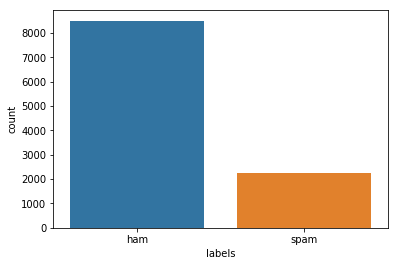

In [36]:
sns.countplot(df['labels'])

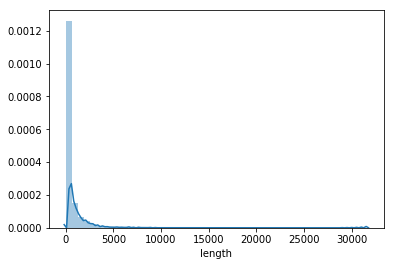

In [38]:
df['length'] = df['message'].apply(len)
sns.distplot(df['length'])

In [48]:
df[df['length']>2500]['labels'].value_counts() #.count()

ham     260
spam    190
Name: labels, dtype: int64

In [49]:
for index in df[df['length']>2500].index.tolist():
    df.drop(index=index, axis=1, inplace=True)
    

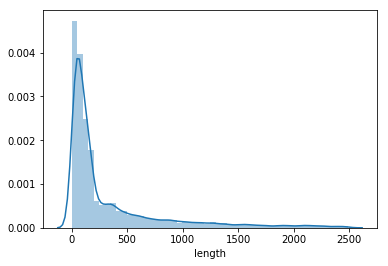

In [50]:
df['length'] = df['message'].apply(len)
sns.distplot(df['length'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9261680b8>,
      dtype=object)

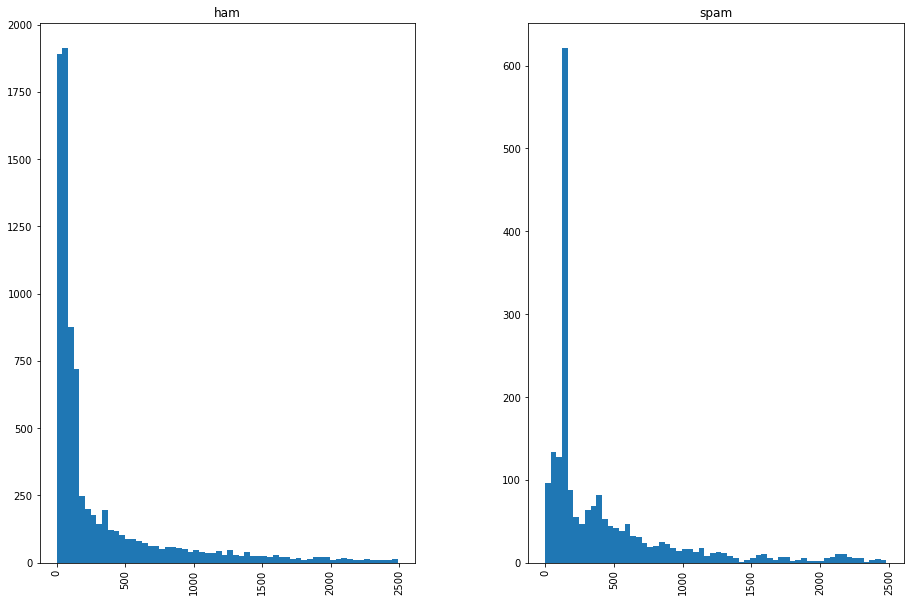

In [51]:
df.hist('length', by='labels', figsize=(15, 10), bins=60)

## Applying NLP; BOW, TF-IDF

In [52]:
import string
from nltk.corpus import stopwords
def text_process(message):
    noPunc = [char for char in message if char not in string.punctuation]
    noPunc = ''.join(noPunc)
    
    return [word for word in noPunc.split() if word not in stopwords.words('english')]

In [53]:
df['message'] = df['message'].apply(text_process)

In [55]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

In [56]:
df['message'].head()

0                                                  yup
1    rolex fover genuine plica watch thank expssing...
2    watch lor saw swatch one thk quite ok ard 116 ...
3    methanol plant status appears methanol plant m...
5    fw crosstex energy driscoll ranch 1 3 meter 98...
Name: message, dtype: object

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(df['message'])

In [58]:
print(len(bow_transformer.vocabulary_))

37648


In [59]:
message_bow = bow_transformer.transform(df['message'])

In [60]:
sparsity = (100.0 * message_bow.nnz/(message_bow.shape[0] * message_bow.shape[1]))
print('sparsity {}'.format(sparsity))

sparsity 0.07220618615096115


In [61]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer_bow = TfidfTransformer().fit(message_bow)

In [63]:
message_tfidf = tfidf_transformer_bow.transform(message_bow)

In [64]:
from sklearn.naive_bayes import MultinomialNB

def buildClassifier(alpha):
    text_classifier = MultinomialNB(alpha=alpha)
    return text_classifier

## Making the pipeline, making it production ready!

In [70]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.01))])


<b> Grid Search for best parameters. </b>

In [71]:
from sklearn.model_selection import GridSearchCV

In [113]:
parameters = {'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.8, 0.9, 1)}
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=10, verbose=1)

In [114]:
grid_search.fit(df['message'], df['labels'])
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   56.7s finished


In [115]:
best_parameters

{'clf__alpha': 0.1}

In [116]:
best_accuracy

0.965125315717894

In [83]:
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.1))])

In [84]:
pipeline.fit(df['message'], df['labels'])

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [111]:
input_word = ['Download this app for free music']
input_word = text_process(input_word)
input_word = [' '.join(input_word)]
pipeline.predict(input_word)

array(['spam'], dtype='<U4')

# Saving the Pipeline to be integrated in our web-app

In [104]:
import pickle

In [105]:
filename = 'textClf.pkl'
pickle.dump(pipeline, open(filename, 'wb'))